<a href="https://colab.research.google.com/github/dnbaohan/graduation_thesis/blob/main/official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
# Install required libraries
!pip install yfinance --quiet
!pip install scikit-learn --quiet
!pip install scikeras --quiet
!pip install tensorflow pandas numpy matplotlib --quiet
!pip install TA-Lib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 41.1 MB/s eta 0:00:00


In [2]:
# =========================
# Standard Libraries
# =========================
import os
import math
import warnings
from datetime import datetime, timedelta
import pywt
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score


# =========================
# Numerical & Data Handling
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Signal Processing & Statistics
# =========================
import pywt
from scipy.fft import fft, ifft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# =========================
# Financial Data & Indicators
# =========================
import yfinance as yf
import talib  # Technical Analysis Library

# =========================
# Machine Learning & Preprocessing
# =========================
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    balanced_accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

# =========================
# Imbalanced Learning
# =========================
from imblearn.over_sampling import SMOTE

# =========================
# Deep Learning (TensorFlow / Keras)
# =========================
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, LayerNormalization,
    LSTM, GRU, Bidirectional,
    Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D,
    Attention, MultiHeadAttention, Concatenate
)

# =========================
# Configuration
# =========================
plt.rcParams["figure.figsize"] = (15, 8)
warnings.filterwarnings("ignore")
np.random.seed(0)
tf.random.set_seed(0)

# =========================
# Directory Setup
# =========================
os.makedirs("results/models", exist_ok=True)
os.makedirs("results/plots", exist_ok=True)

# Data

In [3]:
start_date = "2020-01-01"
end_date   = "2025-01-01"

tickers = {
    "VCB": "VCB.VN",
    "CTG": "CTG.VN",
    "BID": "BID.VN",
    "TCB": "TCB.VN",
}

# Download dữ liệu
stocks_data = {}
for ticker, symbol in tickers.items():
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    stocks_data[symbol] = df
# Hiển thị dữ liệu của tất cả mã
for symbol, df in stocks_data.items():
    print(f"Dữ liệu cổ phiếu: {symbol}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Dữ liệu cổ phiếu: VCB.VN
Dữ liệu cổ phiếu: CTG.VN
Dữ liệu cổ phiếu: BID.VN
Dữ liệu cổ phiếu: TCB.VN


In [4]:
def adf_summary_full(df):
    results = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns  # chỉ lấy cột số

    for col in numeric_cols:
        series = df[col].dropna()
        if len(series) < 20:  # bỏ qua cột có quá ít quan sát
            continue
        adf_result = adfuller(series, autolag='AIC')
        pval = adf_result[1]
        stat = adf_result[0]
        crit = adf_result[4]['5%']
        results.append({
            'Variable': col,
            'ADF Statistic': round(stat, 4),
            'p-value': round(pval, 4),
            '5% Critical Value': round(crit, 4),
            'Stationary': 'Yes' if pval < 0.05 else 'No'
        })

    return pd.DataFrame(results)

# Gọi hàm trên toàn bộ dataframe của bạn
adf_table_full = adf_summary_full(df)
print(adf_table_full)

df.columns


           Variable  ADF Statistic  p-value  5% Critical Value Stationary
0    (Open, TCB.VN)        -1.0578   0.7316            -2.8639         No
1    (High, TCB.VN)        -1.2504   0.6515            -2.8639         No
2     (Low, TCB.VN)        -1.1817   0.6814            -2.8639         No
3   (Close, TCB.VN)        -1.0473   0.7356            -2.8639         No
4  (Volume, TCB.VN)        -5.0345   0.0000            -2.8639        Yes


MultiIndex([(  'Open', 'TCB.VN'),
            (  'High', 'TCB.VN'),
            (   'Low', 'TCB.VN'),
            ( 'Close', 'TCB.VN'),
            ('Volume', 'TCB.VN')],
           names=['Price', 'Ticker'])

In [5]:
# Tạo DataFrame với giá đóng cửa cho từng cổ phiếu
df_close = pd.concat({tk: d['Close'] for tk, d in stocks_data.items()}, axis=1)
df_close.columns = df_close.columns.droplevel(0)  # Đổi tên cột sau khi concat - Removed this line

# Tính toán tỷ lệ log return hàng ngày
daily_log_returns = np.log(df_close / df_close.shift(1))

rows = []

for ticker in daily_log_returns.columns:

    # =========================
    # Base series
    # =========================
    close  = df_close[ticker]
    ret    = daily_log_returns[ticker]
    # Ensure volume, high, and low are Series by using .squeeze() and reindexing
    volume = stocks_data[ticker]["Volume"].squeeze().reindex(close.index)
    high   = stocks_data[ticker]["High"].squeeze().reindex(close.index)
    low    = stocks_data[ticker]["Low"].squeeze().reindex(close.index)

    df_feat = pd.DataFrame({
        "date": ret.index,
        "ticker": ticker,
        "return": ret,
        "return_lag1": ret.shift(1),
        "return_lag5": ret.shift(5),
        "return_lag10": ret.shift(10)
    })

    # =========================
    # 1. Volatility
    # =========================
    df_feat["volatility_21"] = ret.rolling(21).std() * np.sqrt(252)
    df_feat["Vol_5"]  = ret.rolling(5).std()
    df_feat["Vol_10"] = ret.rolling(10).std()
    df_feat["Vol_20"] = ret.rolling(20).std()


    # =========================
    # 2. RSI
    # =========================
    df_feat["RSI_14"] = talib.RSI(close, timeperiod=14)

    # =========================
    # 3. MACD
    # =========================
    macd, macd_sig, _ = talib.MACD(close, 12, 26, 9)
    df_feat["MACD"] = macd
    df_feat["MACD_signal"] = macd_sig

    # =========================
    # 4. Bollinger Bands
    # =========================
    bb_up, bb_mid, bb_low = talib.BBANDS(close, timeperiod=20)
    df_feat["BB_upper"] = bb_up
    df_feat["BB_middle"] = bb_mid
    df_feat["BB_lower"] = bb_low
    df_feat["Boll_width"] = (bb_up - bb_low) / bb_mid
    df_feat["Boll_percB"] = (close - bb_low) / (bb_up - bb_low)

    # =========================
    # 5. Moving Averages
    # =========================
    df_feat["MA_5"]  = ret.rolling(5).mean()
    df_feat["EMA_12"] = ret.ewm(span=12, adjust=False).mean()
    df_feat["EMA_26"] = ret.ewm(span=26, adjust=False).mean()
    df_feat["Trend_20"] = ret.rolling(20).mean()

    # =========================
    # 6. Regime (High/Low vol)
    # =========================
    df_feat["Regime"] = (
        df_feat["Vol_20"] > df_feat["Vol_20"].rolling(60).mean()
    ).astype(int)

    # =========================
    # 7. OBV
    # =========================
    df_feat["OBV"] = talib.OBV(close, volume)

    # =========================
    # 8. Forward returns
    # =========================
    for k in [5, 10, 21]:
        df_feat[f"ret_{k}"] = np.log(close / close.shift(k))

    # =========================
    # 9. Momentum
    # =========================
    short_mom = close / close.shift(5) - 1
    long_mom  = close / close.shift(21) - 1

    df_feat["momentum_diff"] = short_mom - long_mom
    df_feat["momentum_90"] = close / close.shift(90) - 1


    # =========================
    # 10. MA / EMA ratios
    # =========================
    df_feat["SMA20_ratio"] = close / close.rolling(20).mean() - 1
    df_feat["SMA50_ratio"] = close / close.rolling(50).mean() - 1
    df_feat["EMA12_ratio"] = close / close.ewm(span=12).mean() - 1
    df_feat["EMA26_ratio"] = close / close.ewm(span=26).mean() - 1

    # =========================
    # 11. ATR (normalized)
    # =========================
    tr = np.maximum(
        high - low,
        np.maximum(
            (high - close.shift()).abs(),
            (low - close.shift()).abs()
        )
    )
    df_feat["ATR_14"] = tr.rolling(14).mean() / close

    # =========================
    # 12. Volume
    # =========================
    log_vol = np.log(volume.replace(0, np.nan))
    df_feat["Volume_diff"] = log_vol.diff()

    rows.append(df_feat)

# =========================
# Final feature table
# =========================
features = (
    pd.concat(rows)
    .sort_values(["ticker", "date"])
    .reset_index(drop=True)
)

# 7) Target = return ngày kế tiếp
features = features.sort_values(["ticker", "date"])
features["target"] = (
    features.groupby("ticker")["return"]
            .transform(lambda s: s.shift(-1).rolling(5).mean())
)


# 8) Làm sạch dữ liệu (bỏ tất cả NaN phát sinh)
features = features.dropna().reset_index(drop=True)

# Kiểm tra kết quả cuối cùng
print("Final dataset:", features.shape)
print(features.head())

Final dataset: (4547, 36)
        date  ticker    return  return_lag1  return_lag5  return_lag10  \
0 2020-05-19  BID.VN  0.005128     0.007742     0.001298      0.000000   
1 2020-05-20  BID.VN  0.001278     0.005128     0.026873      0.019636   
2 2020-05-21  BID.VN  0.013951     0.001278     0.002522      0.042154   
3 2020-05-22  BID.VN -0.010127     0.013951    -0.028099      0.011913   
4 2020-05-25  BID.VN  0.008866    -0.010127     0.007742      0.013072   

   volatility_21     Vol_5    Vol_10    Vol_20  ...    ret_21  momentum_diff  \
0       0.375966  0.019775  0.018367  0.024299  ...  0.047129      -0.033990   
1       0.375977  0.014643  0.018239  0.024180  ...  0.045730      -0.058155   
2       0.376159  0.016371  0.014162  0.017873  ...  0.067734      -0.070081   
3       0.282645  0.008950  0.014767  0.016140  ...  0.124485      -0.114430   
4       0.250277  0.009094  0.014517  0.016143  ...  0.091032      -0.076024   

   momentum_90  SMA20_ratio  SMA50_ratio  EMA12_

In [6]:
df.columns

MultiIndex([(  'Open', 'TCB.VN'),
            (  'High', 'TCB.VN'),
            (   'Low', 'TCB.VN'),
            ( 'Close', 'TCB.VN'),
            ('Volume', 'TCB.VN')],
           names=['Price', 'Ticker'])

# EDA

In [7]:
# Close price table: columns are symbols like 'VCB.VN', 'CTG.VN', ...
df_close = pd.concat({symbol: d["Close"] for symbol, d in stocks_data.items()}, axis=1)

# Daily log returns
logret = np.log(df_close).diff().dropna()

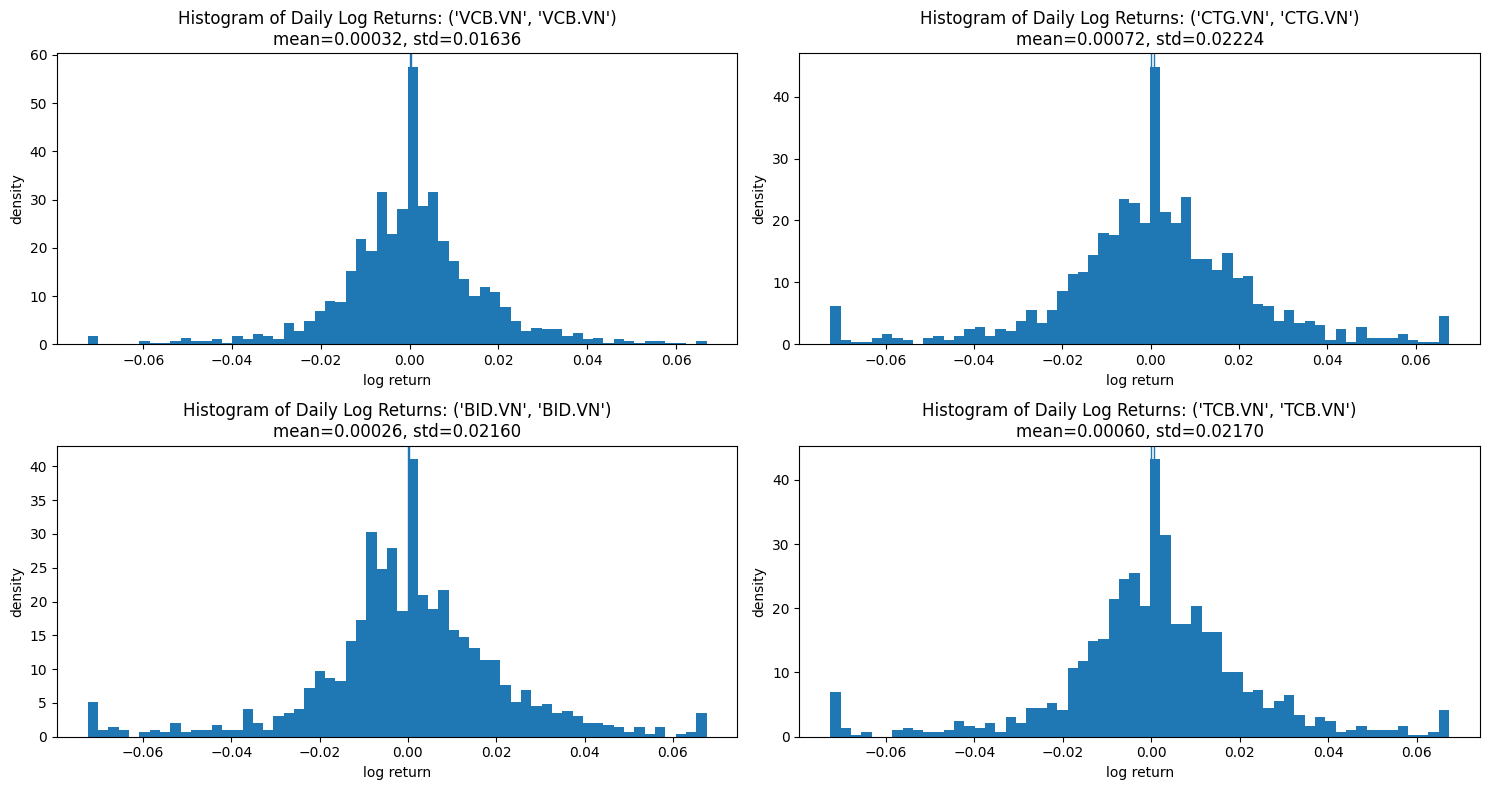

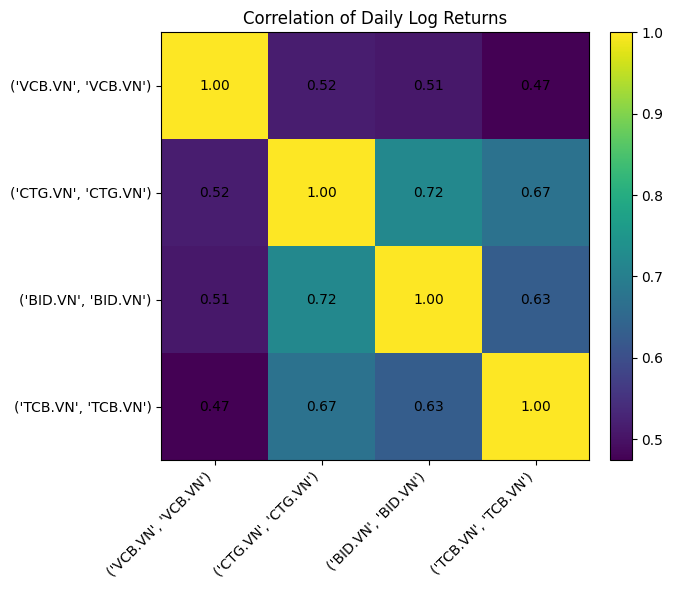

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 8)

# --- DATA ---
df_close = pd.concat({symbol: d["Close"] for symbol, d in stocks_data.items()}, axis=1)
logret = np.log(df_close).diff().dropna()   # daily log return

tickers = logret.columns.tolist()
n = len(tickers)

# ---------- (B) Distribution: histograms (2x2) ----------
rows = int(np.ceil(n / 2))
fig, axes = plt.subplots(rows, 2, figsize=(15, 4 * rows))
axes = np.array(axes).reshape(-1)

for i, tk in enumerate(tickers):
    r = logret[tk].dropna()
    axes[i].hist(r, bins=60, density=True)
    axes[i].axvline(0, linewidth=1)
    axes[i].axvline(r.mean(), linewidth=1)
    axes[i].set_title(f"Histogram of Daily Log Returns: {tk}\nmean={r.mean():.5f}, std={r.std():.5f}")
    axes[i].set_xlabel("log return")
    axes[i].set_ylabel("density")

# hide extra axes if n is odd
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# ---------- (E) Correlation heatmap (matplotlib only) ----------
corr = logret.corr()

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr.values, aspect="equal")
ax.set_xticks(range(n)); ax.set_yticks(range(n))
ax.set_xticklabels(tickers, rotation=45, ha="right")
ax.set_yticklabels(tickers)
ax.set_title("Correlation of Daily Log Returns")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# annotate cells
for i in range(n):
    for j in range(n):
        ax.text(j, i, f"{corr.iloc[i,j]:.2f}", ha="center", va="center")
plt.tight_layout()
plt.show()

# Data Check

## Sanity Check

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np

# =============================
# 1) Quality-check functions
# =============================
def _ensure_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if not isinstance(out.index, pd.DatetimeIndex):
        out.index = pd.to_datetime(out.index, errors="coerce")
    out = out.loc[out.index.notna()]
    return out

def _coerce_numeric(df: pd.DataFrame, cols) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _largest_gaps_days(dt_index: pd.DatetimeIndex, top_k=5):
    if len(dt_index) < 2:
        return []
    s = pd.Series(dt_index.sort_values())
    gaps = (s.diff().dt.days).dropna()
    if gaps.empty:
        return []
    top = gaps.sort_values(ascending=False).head(top_k)
    res = []
    for i, gap_days in top.items():
        prev_date = s.iloc[i - 1].date()
        next_date = s.iloc[i].date()
        res.append((int(gap_days), str(prev_date), str(next_date)))
    return res

def screen_and_report(
    stocks_data: dict,
    required_cols=("Open", "High", "Low", "Close", "Volume"),
    gap_threshold_days=7,
    check_union_calendar=True
):
    cleaned_data = {}
    issues = {}

    # union calendar across all tickers (optional)
    all_dates = []
    for tk, df in stocks_data.items():
        df2 = _ensure_datetime_index(df)
        all_dates.append(df2.index)
    union_calendar = pd.DatetimeIndex(sorted(set(np.concatenate([d.values for d in all_dates]))))

    rows = []
    for ticker, df in stocks_data.items():
        note = []

        # date index validity + sorting
        df1 = _ensure_datetime_index(df)
        if not df1.index.is_monotonic_increasing:
            note.append("Index not sorted -> sorted by date.")
            df1 = df1.sort_index()

        # duplicates by date (duplicate (date, ticker))
        dup_count = int(df1.index.duplicated().sum())
        if dup_count > 0:
            note.append(f"Found {dup_count} duplicated dates -> kept first.")
            df1 = df1[~df1.index.duplicated(keep="first")]

        # column presence
        missing_cols = [c for c in required_cols if c not in df1.columns]
        if missing_cols:
            note.append(f"Missing required columns: {missing_cols}")

        # numeric coercion
        cols_to_use = [c for c in required_cols if c in df1.columns]
        df2 = _coerce_numeric(df1, cols_to_use)

        # missing ratios
        miss_ratio = df2[cols_to_use].isna().mean().to_dict() if cols_to_use else {}

        # coverage + gaps
        n_rows = len(df2)
        start_date = str(df2.index.min().date()) if n_rows else None
        end_date = str(df2.index.max().date()) if n_rows else None

        largest_gaps = _largest_gaps_days(df2.index, top_k=5)
        big_gaps = [g for g in largest_gaps if g[0] >= gap_threshold_days]
        if big_gaps:
            note.append(f"Large gaps (>= {gap_threshold_days} days): {big_gaps}")

        # missing vs union calendar (within ticker's range)
        missing_vs_union = None
        if check_union_calendar and n_rows:
            missing_dates = union_calendar.difference(df2.index)
            missing_dates = missing_dates[(missing_dates >= df2.index.min()) & (missing_dates <= df2.index.max())]
            missing_vs_union = int(len(missing_dates))
            if missing_vs_union > 0:
                note.append(f"Missing {missing_vs_union} dates vs union calendar (within range).")

        cleaned_data[ticker] = df2
        issues[ticker] = {"largest_gaps_top5": largest_gaps, "big_gaps": big_gaps, "notes": note}

        rows.append({
            "ticker": ticker,
            "n_rows": n_rows,
            "start_date": start_date,
            "end_date": end_date,
            "duplicate_dates_removed": dup_count,
            "missing_ratio_Open": round(miss_ratio.get("Open", np.nan), 4),
            "missing_ratio_High": round(miss_ratio.get("High", np.nan), 4),
            "missing_ratio_Low": round(miss_ratio.get("Low", np.nan), 4),
            "missing_ratio_Close": round(miss_ratio.get("Close", np.nan), 4),
            "missing_ratio_Volume": round(miss_ratio.get("Volume", np.nan), 4),
            "missing_vs_union_calendar": missing_vs_union        })

    report_df = pd.DataFrame(rows).sort_values("ticker").reset_index(drop=True)
    return cleaned_data, report_df, issues


# =============================
# 2) Apply to 4 Vietnamese stocks
# =============================
tickers = ["BID.VN", "CTG.VN", "TCB.VN", "VCB.VN"]
start = "2020-01-01"
end = "2025-01-01"

stocks_data = {}
for tk in tickers:
    df = yf.download(tk, start=start, end=end, auto_adjust=False, progress=False)
    # standardize column names (yfinance sometimes gives multi-index or lowercase)
    df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
    stocks_data[tk] = df

cleaned_data, quality_report, issues = screen_and_report(
    stocks_data,
    required_cols=("Open", "High", "Low", "Close", "Volume"),
    gap_threshold_days=7,
    check_union_calendar=True
)

print("=== QUALITY REPORT (4 tickers) ===")
print(quality_report.to_string(index=False))

print("\n=== Example detailed issues (BID.VN) ===")
print(issues["BID.VN"])

=== QUALITY REPORT (4 tickers) ===
ticker  n_rows start_date   end_date  duplicate_dates_removed  missing_ratio_Open  missing_ratio_High  missing_ratio_Low  missing_ratio_Close  missing_ratio_Volume  missing_vs_union_calendar
BID.VN    1250 2020-01-02 2024-12-31                        0                 0.0                 0.0                0.0                  0.0                   0.0                          0
CTG.VN    1250 2020-01-02 2024-12-31                        0                 0.0                 0.0                0.0                  0.0                   0.0                          0
TCB.VN    1247 2020-01-02 2024-12-31                        0                 0.0                 0.0                0.0                  0.0                   0.0                          3
VCB.VN    1250 2020-01-02 2024-12-31                        0                 0.0                 0.0                0.0                  0.0                   0.0                          0

=== Examp

## Closing Price Trend

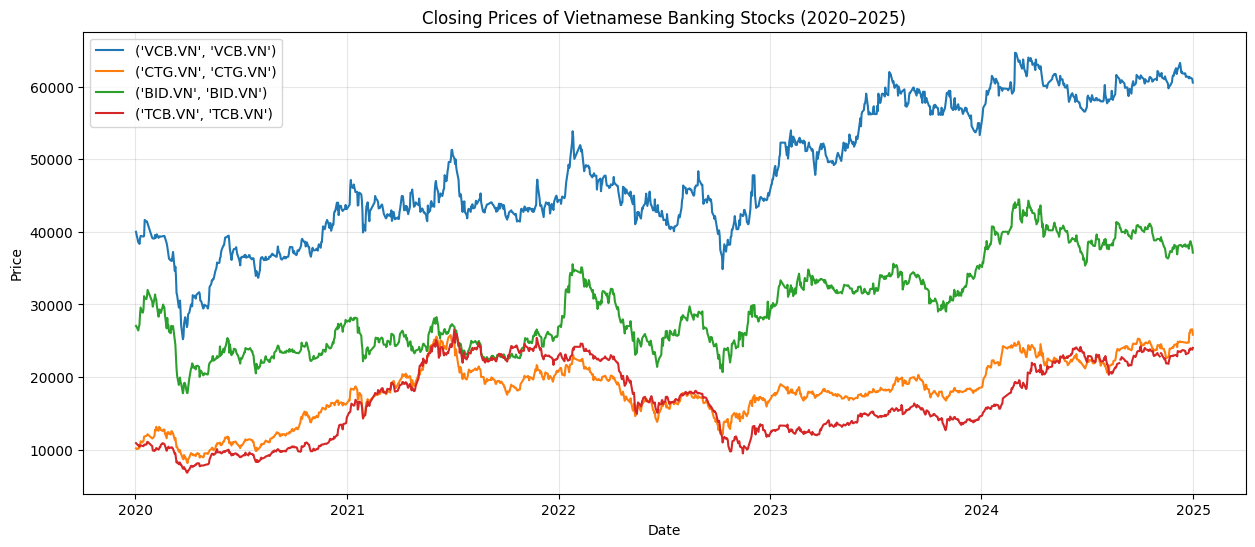

In [10]:
plt.figure(figsize=(15,6))
for col in df_close.columns:
    plt.plot(df_close.index, df_close[col], label=col)

plt.title("Closing Prices of Vietnamese Banking Stocks (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Return Time Series

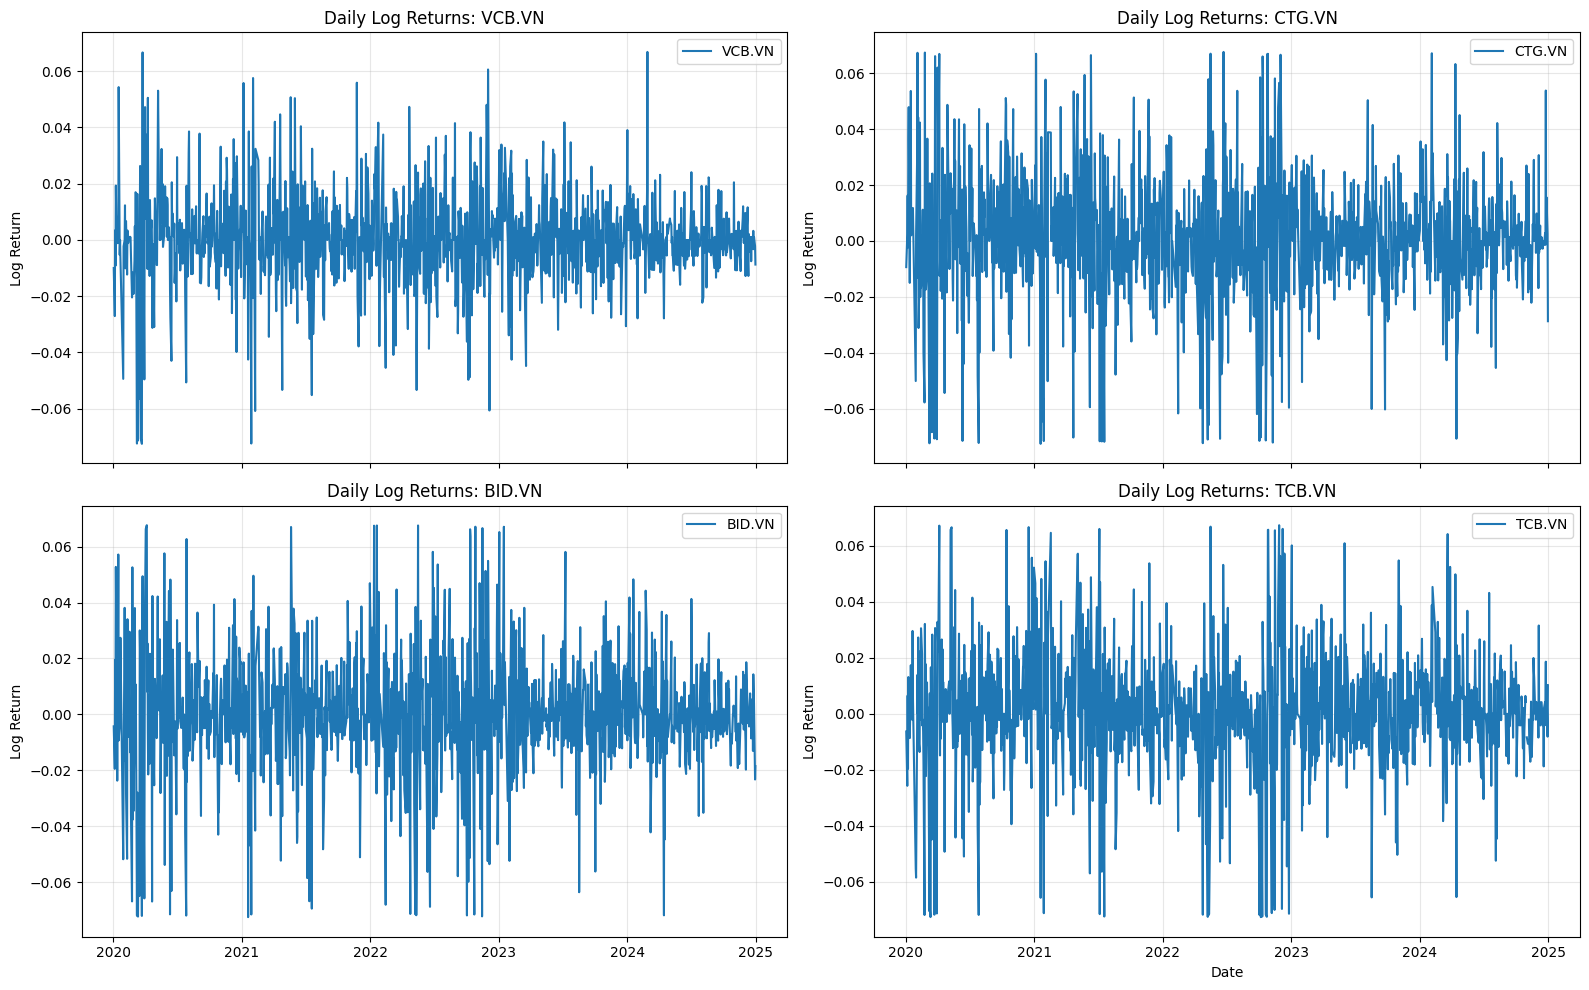

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharex=True)
axes = axes.flatten()

for i, col in enumerate(daily_log_returns.columns):
    axes[i].plot(
        daily_log_returns.index,
        daily_log_returns[col],
        label=col
    )
    axes[i].set_title(f"Daily Log Returns: {col}")
    axes[i].set_ylabel("Log Return")
    axes[i].grid(alpha=0.3)
    axes[i].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

## Return Distribution

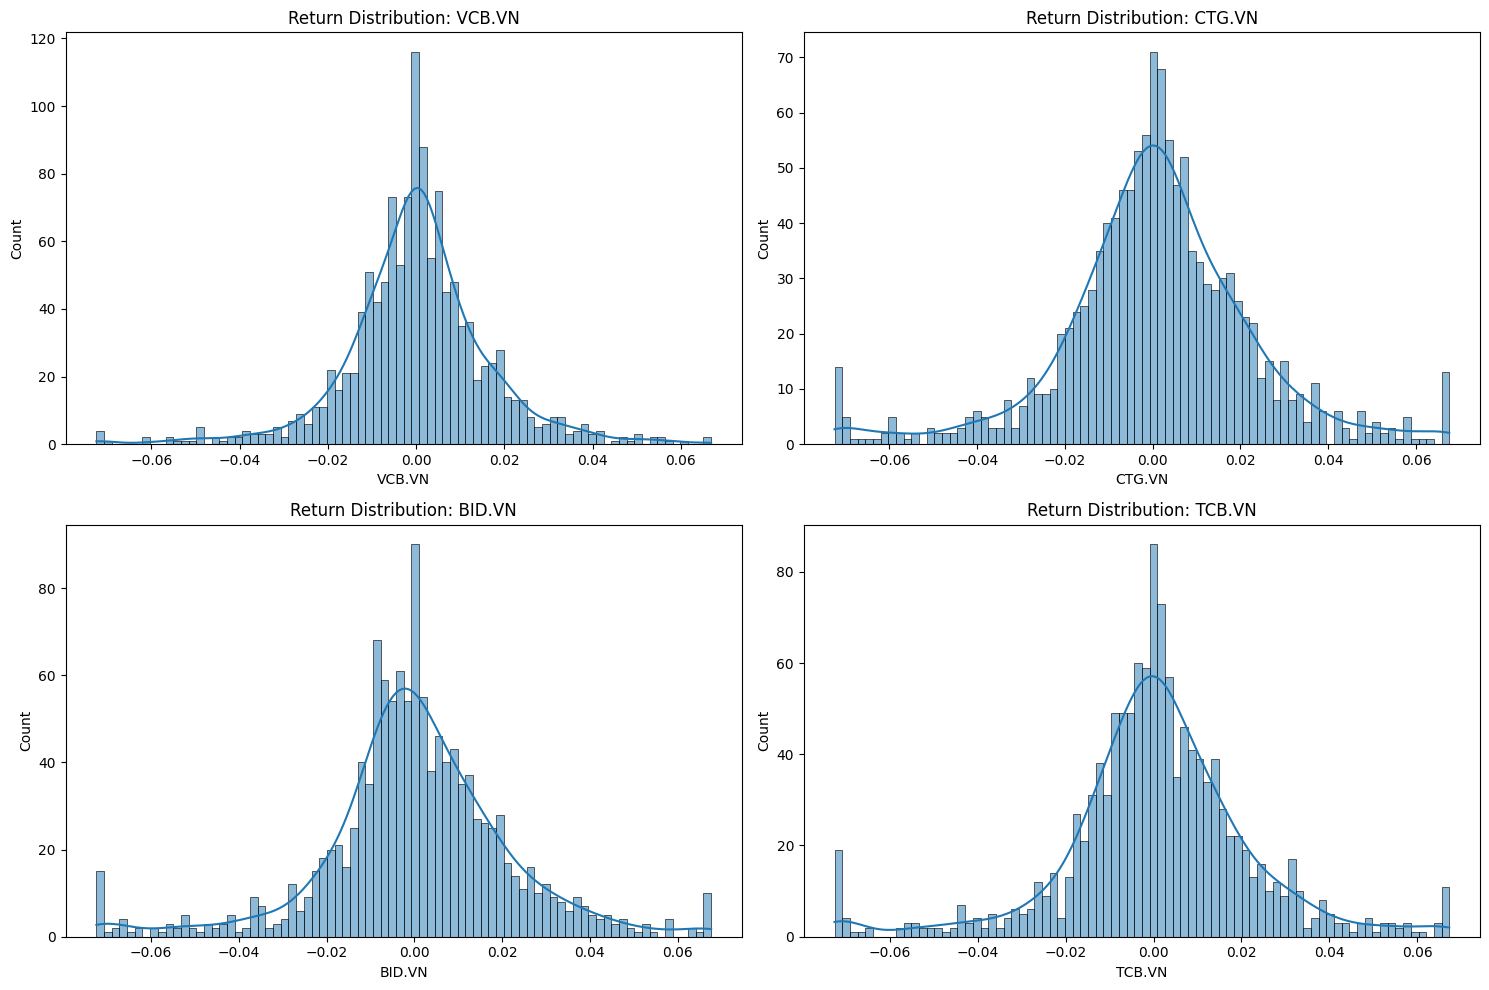

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes = axes.flatten()

for i, col in enumerate(daily_log_returns.columns):
    sns.histplot(
        daily_log_returns[col].dropna(),
        bins=80,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(f"Return Distribution: {col}")

plt.tight_layout()
plt.show()

## Rolling Volatility

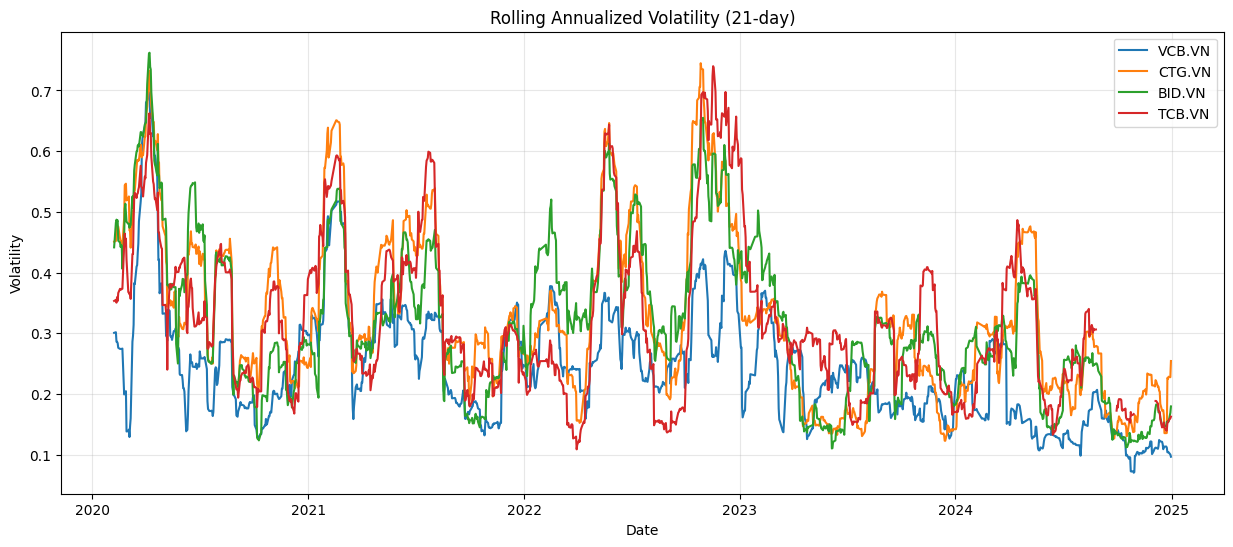

In [13]:
plt.figure(figsize=(15,6))
for col in daily_log_returns.columns:
    vol = daily_log_returns[col].rolling(21).std() * np.sqrt(252)
    plt.plot(vol.index, vol, label=col)

plt.title("Rolling Annualized Volatility (21-day)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Stationarity Test (ADF) – Returns vs Prices

In [14]:
def adf_test(series, name=""):
    result = adfuller(series.dropna())
    print(f"{name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("-"*40)

# Prices
for col in df_close.columns:
    adf_test(df_close[col], f"PRICE - {col}")

# Returns
for col in daily_log_returns.columns:
    adf_test(daily_log_returns[col], f"RETURN - {col}")


PRICE - ('VCB.VN', 'VCB.VN')
ADF Statistic: -1.1570
p-value: 0.6918
----------------------------------------
PRICE - ('CTG.VN', 'CTG.VN')
ADF Statistic: -1.5824
p-value: 0.4924
----------------------------------------
PRICE - ('BID.VN', 'BID.VN')
ADF Statistic: -1.4729
p-value: 0.5469
----------------------------------------
PRICE - ('TCB.VN', 'TCB.VN')
ADF Statistic: -1.0473
p-value: 0.7356
----------------------------------------
RETURN - VCB.VN
ADF Statistic: -15.6225
p-value: 0.0000
----------------------------------------
RETURN - CTG.VN
ADF Statistic: -14.9415
p-value: 0.0000
----------------------------------------
RETURN - BID.VN
ADF Statistic: -14.9176
p-value: 0.0000
----------------------------------------
RETURN - TCB.VN
ADF Statistic: -32.7566
p-value: 0.0000
----------------------------------------


## FFT of Returns (Per Stock)

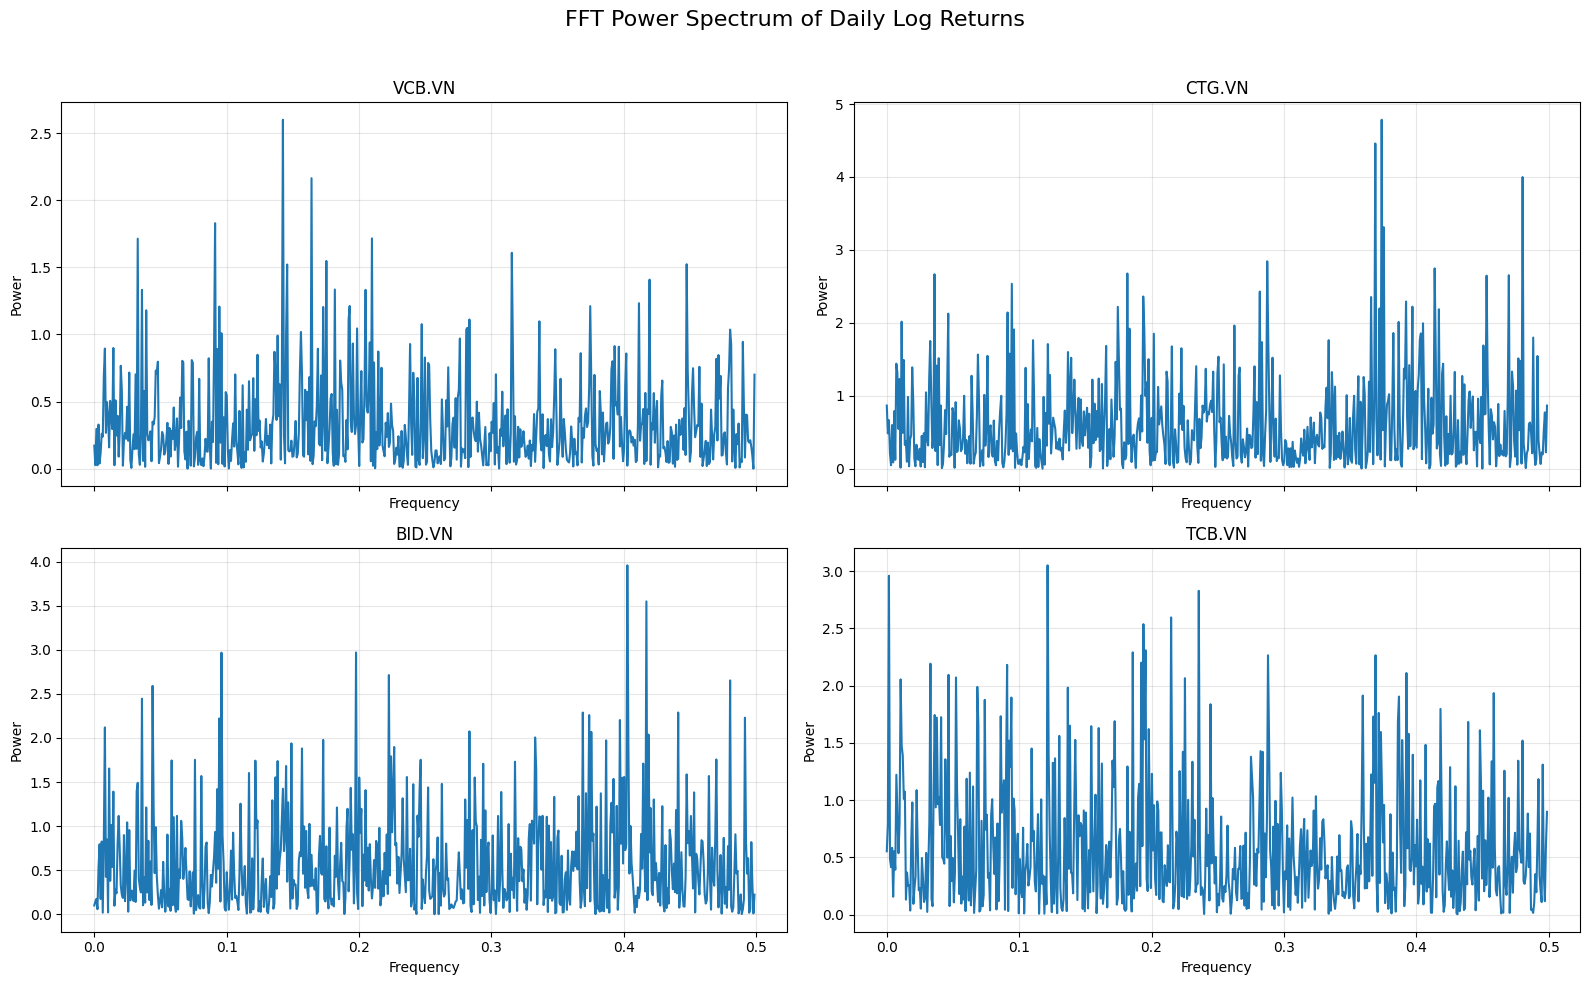

In [15]:
def fft_analysis(series, title, ax):
    series = series.dropna().values
    N = len(series)

    fft_vals = np.fft.fft(series)
    freqs = np.fft.fftfreq(N)

    power = np.abs(fft_vals) ** 2

    ax.plot(freqs[:N//2], power[:N//2])
    ax.set_title(title)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")
    ax.grid(alpha=0.3)

# ----- Create 2x2 subplot -----
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()

# ----- Loop through 4 stocks -----
for i, col in enumerate(daily_log_returns.columns[:4]):
    fft_analysis(daily_log_returns[col], col, axes[i])

fig.suptitle("FFT Power Spectrum of Daily Log Returns", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# LSTM

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, balanced_accuracy_score
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ============================================================
# 0) Utils
# ============================================================
def create_sequences(X, y, seq_len):
    """
    X: (T, n_features)
    y: (T,)
    returns:
      X_seq: (T-seq_len, seq_len, n_features)
      y_seq: (T-seq_len,)
    y at time t corresponds to the step immediately after the sequence end:
      seq uses X[t-seq_len : t], target is y[t]
    """
    Xs, ys = [], []
    for t in range(seq_len, len(X)):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.asarray(Xs, dtype=np.float32), np.asarray(ys, dtype=np.float32)

def safe_auc(y_true_bin, y_prob):
    y_true_bin = np.asarray(y_true_bin).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    if len(np.unique(y_true_bin)) < 2:
        return np.nan
    return roc_auc_score(y_true_bin, y_prob)

def tune_threshold_balacc(y_true, y_prob, lo=0.05, hi=0.95, n=181):
    """
    Tune threshold to maximize Balanced Accuracy on validation.
    Prevents all-positive collapse.
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    ts = np.linspace(lo, hi, n)

    best_t, best_s = 0.5, -1.0
    for t in ts:
        y_pred = (y_prob >= t).astype(int)
        s = balanced_accuracy_score(y_true, y_pred)
        if s > best_s:
            best_s, best_t = s, t
    return float(best_t), float(best_s)

def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for binary classification.
    alpha: weight for positive class
    gamma: focusing parameter
    """
    def loss(y_true, y_prob):
        y_true = tf.cast(y_true, tf.float32)
        eps = tf.keras.backend.epsilon()
        y_prob = tf.clip_by_value(y_prob, eps, 1.0 - eps)

        pt = tf.where(tf.equal(y_true, 1.0), y_prob, 1.0 - y_prob)
        w  = tf.where(tf.equal(y_true, 1.0), alpha, 1.0 - alpha)
        return -tf.reduce_mean(w * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss

# ============================================================
# 1) Model (improved LSTM baseline)
# ============================================================
def build_lstm_multitask_v2(
    input_shape,
    units=64,
    dropout=0.2,
    l2=1e-6,
    dense_units=32
):
    """
    input_shape: (LOOKBACK, n_features)
    outputs:
      - y_reg_z: standardized regression output
      - y_up: direction sigmoid
    """
    inp = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.SpatialDropout1D(dropout)(inp)

    x = tf.keras.layers.LSTM(
        units, return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(l2)
    )(x)
    x = tf.keras.layers.LayerNormalization()(x)

    x = tf.keras.layers.LSTM(
        max(16, units // 2), return_sequences=False,
        kernel_regularizer=tf.keras.regularizers.l2(l2)
    )(x)
    x = tf.keras.layers.LayerNormalization()(x)

    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    y_reg_z = tf.keras.layers.Dense(1, name="y_reg_z")(x)
    y_up    = tf.keras.layers.Dense(1, activation="sigmoid", name="y_up")(x)

    return tf.keras.Model(inp, [y_reg_z, y_up])

# ============================================================
# 2) Train + Eval loop (per ticker)
# ============================================================
LOOKBACK = 30
non_feature = ["date", "ticker", "target"]
feature_cols = [c for c in features.columns if c not in non_feature]

df = features.copy()
df["date"] = pd.to_datetime(df["date"])

lstm_models, lstm_scalers, lstm_histories, lstm_splits, lstm_meta = {}, {}, {}, {}, {}
summary_rows = []

for tk, dft in df.groupby("ticker"):
    dft = dft.sort_values("date").reset_index(drop=True)

    X = dft[feature_cols].values.astype(np.float32)
    y = dft["target"].values.astype(np.float32)

    if len(dft) < (LOOKBACK + 80):
        print(f"⚠️ {tk}: dữ liệu quá ít ({len(dft)} dòng) -> bỏ qua")
        continue

    split_index = int(len(dft) * 0.8)
    X_train_raw, X_test_raw = X[:split_index], X[split_index:]
    y_train_raw, y_test_raw = y[:split_index], y[split_index:]

    # scale X (train only)
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled  = scaler.transform(X_test_raw)

    # sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_raw, LOOKBACK)
    X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_raw,  LOOKBACK)

    if len(X_train_seq) < 50 or len(X_test_seq) < 30:
        print(f"⚠️ {tk}: số sequence quá ít -> bỏ qua")
        continue

    # validation tail (20% of train sequences) + purge gap to reduce overlap leakage
    val_size = max(1, int(0.2 * len(X_train_seq)))
    gap = LOOKBACK

    if len(X_train_seq) <= (val_size + gap + 5):
        # fallback if too short
        gap = 0

    X_tr, y_tr = X_train_seq[:-val_size-gap], y_train_seq[:-val_size-gap]
    X_val, y_val = X_train_seq[-val_size:], y_train_seq[-val_size:]

    # standardize regression target on train only
    y_mu = float(np.mean(y_tr))
    y_sd = float(np.std(y_tr) + 1e-8)

    y_tr_z  = ((y_tr  - y_mu) / y_sd).astype(np.float32)
    y_val_z = ((y_val - y_mu) / y_sd).astype(np.float32)

    # direction labels
    y_tr_up  = (y_tr > 0).astype(np.float32)
    y_val_up = (y_val > 0).astype(np.float32)

    # focal loss (alpha based on class balance is optional; keep stable default)
    focal = binary_focal_loss(gamma=2.0, alpha=0.25)

    # build model
    model = build_lstm_multitask_v2(
        input_shape=(LOOKBACK, X_train_seq.shape[2]),
        units=64,
        dropout=0.2,
        l2=1e-6,
        dense_units=32
    )

    opt = Adam(learning_rate=1e-3, clipnorm=1.0)
    model.compile(
        optimizer=opt,
        loss={
            "y_reg_z": tf.keras.losses.Huber(delta=1.0),
            "y_up": focal
        },
        loss_weights={"y_reg_z": 1.0, "y_up": 0.2},
        metrics={"y_up": [tf.keras.metrics.AUC(name="auc")]}
    )

    early_stop = EarlyStopping(
        monitor="val_y_up_auc",
        mode="max",
        patience=10,
        restore_best_weights=True
    )
    rlr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-5,
        verbose=1
    )

    print(f"\n===== Training IMPROVED LSTM for {tk} | TrainSeq={len(X_tr)} ValSeq={len(X_val)} =====")
    history = model.fit(
        X_tr, {"y_reg_z": y_tr_z, "y_up": y_tr_up},
        validation_data=(X_val, {"y_reg_z": y_val_z, "y_up": y_val_up}),
        epochs=150,
        batch_size=32,
        callbacks=[early_stop, rlr],
        verbose=1
    )

    # store
    lstm_models[tk] = model
    lstm_scalers[tk] = scaler
    lstm_histories[tk] = history
    lstm_splits[tk] = (X_train_seq, X_test_seq, y_train_seq, y_test_seq, X_val, y_val)
    lstm_meta[tk] = {"y_mu": y_mu, "y_sd": y_sd}

    # ============================================================
    # 3) Evaluate
    # ============================================================
    y_reg_z_pred, y_up_prob = model.predict(X_test_seq, verbose=0)
    y_reg_z_pred = y_reg_z_pred.reshape(-1)
    y_up_prob    = y_up_prob.reshape(-1)

    # inverse regression
    y_pred = y_reg_z_pred * y_sd + y_mu

    mse  = float(mean_squared_error(y_test_seq, y_pred))
    rmse = float(np.sqrt(mse))
    mae  = float(mean_absolute_error(y_test_seq, y_pred))

    # tune threshold on val via balanced accuracy
    _, y_val_prob = model.predict(X_val, verbose=0)
    y_val_prob = y_val_prob.reshape(-1)
    y_val_true = (y_val > 0).astype(int)

    best_t, best_balacc = tune_threshold_balacc(y_val_true, y_val_prob, lo=0.05, hi=0.95, n=181)

    y_true_bin = (y_test_seq > 0).astype(int)
    y_pred_bin = (y_up_prob >= best_t).astype(int)

    directional_acc = float(accuracy_score(y_true_bin, y_pred_bin))
    precision = float(precision_score(y_true_bin, y_pred_bin, zero_division=0))
    recall    = float(recall_score(y_true_bin, y_pred_bin, zero_division=0))
    f1        = float(f1_score(y_true_bin, y_pred_bin, zero_division=0))
    auc       = float(safe_auc(y_true_bin, y_up_prob))

    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1]).ravel()

    summary_rows.append({
        "Ticker": tk,
        "N_test_seq": int(len(y_test_seq)),
        "RMSE": rmse,
        "MAE": mae,
        "Directional_Acc": directional_acc,
        "Precision_Up": precision,
        "Recall_Up": recall,
        "F1_Up": f1,
        "AUC": auc,
        "Best_Threshold": float(best_t),
        "Val_BalAcc_at_bestT": float(best_balacc),
        "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp)
    })

# ============================================================
# 4) Summary table
# ============================================================
summary_lstm_df = pd.DataFrame(summary_rows).sort_values("RMSE").reset_index(drop=True)
display_cols = [
    "Ticker","N_test_seq","RMSE","MAE",
    "Directional_Acc","Precision_Up","Recall_Up","F1_Up","AUC",
    "Best_Threshold","Val_BalAcc_at_bestT","TN","FP","FN","TP"
]
print("\n===== LSTM SUMMARY =====")
print(summary_lstm_df[display_cols].to_string(index=False))


===== Training IMPROVED LSTM for BID.VN | TrainSeq=688 ValSeq=179 =====
Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - loss: 0.7908 - y_reg_z_loss: 0.7270 - y_up_auc: 0.4838 - y_up_loss: 0.3178 - val_loss: 0.3800 - val_y_reg_z_loss: 0.3628 - val_y_up_auc: 0.3557 - val_y_up_loss: 0.2525 - learning_rate: 0.0010
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.4894 - y_reg_z_loss: 0.4594 - y_up_auc: 0.4621 - y_up_loss: 0.1511 - val_loss: 0.2300 - val_y_reg_z_loss: 0.2252 - val_y_up_auc: 0.3744 - val_y_up_loss: 0.1570 - learning_rate: 0.0010
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.4331 - y_reg_z_loss: 0.4088 - y_up_auc: 0.4873 - y_up_loss: 0.1209 - val_loss: 0.2024 - val_y_reg_z_loss: 0.1804 - val_y_up_auc: 0.3146 - val_y_up_loss: 0.1568 - learning_rate: 0.0010
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.3784 - y_reg_z_loss: 0.3562 - y_up_auc: 0.4819 - y_up_loss: 0.1102 - val_loss: 0.2069 - val_y_reg_z_loss: 0.1880 - val_y_up_

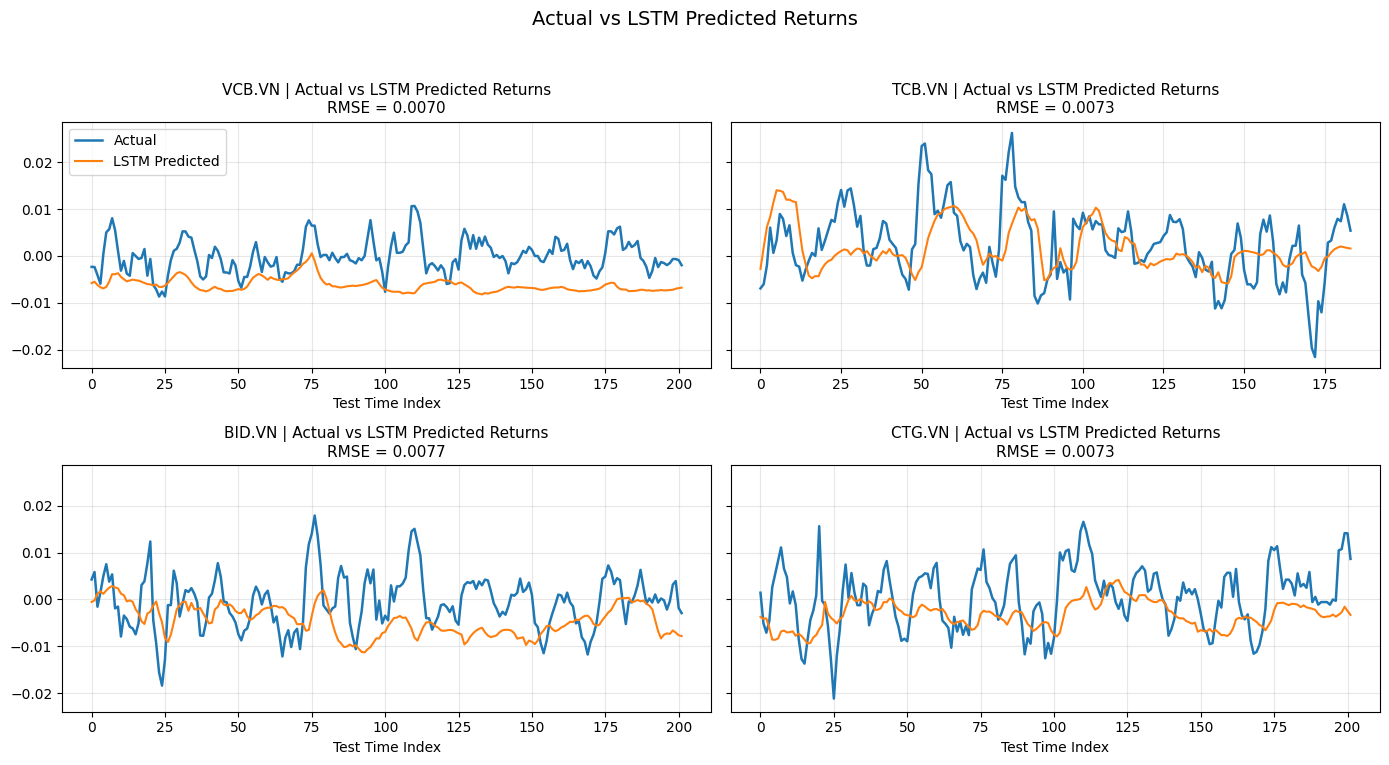

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

def plot_4stocks_actual_vs_lstm(
    stock_data,   # dict: {ticker: (dates, y_true, y_pred)}
    max_points=250
):
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
    axes = axes.flatten()

    for ax, (ticker, (y_true, y_pred)) in zip(axes, stock_data.items()):

        if len(y_true) > max_points:
            # dates  = dates[-max_points:]
            y_true = y_true[-max_points:]
            y_pred = y_pred[-max_points:]

        # RMSE
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        ax.set_xlabel("Test Time Index")
        ax.plot(y_true, label="Actual", linewidth=1.8)
        ax.plot(y_pred, label="LSTM Predicted")

        ax.set_title(
            f"{ticker} | Actual vs LSTM Predicted Returns\nRMSE = {rmse:.4f}",
            fontsize=11
        )
        ax.grid(alpha=0.3)

    axes[0].legend(loc="upper left")
    fig.suptitle("Actual vs LSTM Predicted Returns", fontsize=14)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
stock_data = {}

for tk in ["VCB.VN", "TCB.VN", "BID.VN", "CTG.VN"]:
    model = lstm_models[tk]
    y_mu = lstm_meta[tk]["y_mu"]
    y_sd = lstm_meta[tk]["y_sd"]

    X_train_seq, X_test_seq, y_train_seq, y_test_seq, X_val, y_val = lstm_splits[tk]

    y_reg_z_pred, _ = model.predict(X_test_seq, verbose=0)
    y_pred = y_reg_z_pred.reshape(-1) * y_sd + y_mu

    dft = df[df["ticker"] == tk].sort_values("date")
    split_index = int(len(dft) * 0.8)
    # dates = dft["date"].iloc[split_index + LOOKBACK:].values

    stock_data[tk] = (y_test_seq, y_pred)

plot_4stocks_actual_vs_lstm(stock_data)

# Transformer

In [18]:
# ---------- Positional Encoding ----------
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position: int, d_model: int):
        super().__init__()
        pos = np.arange(position)[:, np.newaxis]
        i   = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads  = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

def transformer_encoder(x, num_heads, key_dim, ff_dim, dropout=0.2):
    attn_out = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim, dropout=dropout
    )(x, x)
    attn_out = tf.keras.layers.Dropout(dropout)(attn_out)
    x = tf.keras.layers.Add()([x, attn_out])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    ff = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    ff = tf.keras.layers.Dense(x.shape[-1])(ff)
    x = tf.keras.layers.Add()([x, ff])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x


In [19]:
def build_transformer_multitask(
    input_shape,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    num_blocks=3,
    dropout=0.2,
    use_conv_frontend=True
):
    """
    input_shape: (LOOKBACK, n_features)
    outputs:
      - y_reg_z: standardized return (regression)
      - y_up: probability of Up (classification)
    """
    inputs = tf.keras.Input(shape=input_shape)

    # Project features -> d_model
    x = tf.keras.layers.Dense(d_model)(inputs)

    # Optional local-pattern front-end (often helps for financial series)
    if use_conv_frontend:
        x = tf.keras.layers.Conv1D(filters=d_model, kernel_size=3, padding="causal", activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout)(x)

    x = PositionalEncoding(position=input_shape[0], d_model=d_model)(x)

    key_dim = max(8, d_model // num_heads)
    for _ in range(num_blocks):
        x = transformer_encoder(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    # Head 1: regression on standardized target
    y_reg_z = tf.keras.layers.Dense(1, name="y_reg_z")(x)

    # Head 2: direction probability
    y_up = tf.keras.layers.Dense(1, activation="sigmoid", name="y_up")(x)

    return tf.keras.Model(inputs, [y_reg_z, y_up])

In [20]:
def make_weighted_bce(w_pos, w_neg):
    # w_pos applies to y_true==1, w_neg applies to y_true==0
    def weighted_bce(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        w = y_true * w_pos + (1.0 - y_true) * w_neg
        return tf.reduce_mean(bce * w)
    return weighted_bce

In [21]:
import numpy as np
from sklearn.metrics import f1_score

def tune_threshold(y_true_bin, y_prob, lo=0.3, hi=0.7, n=81):
    ths = np.linspace(lo, hi, n)
    best_t, best_f1 = 0.5, -1
    for t in ths:
        f1 = f1_score(y_true_bin, (y_prob > t).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1


In [22]:

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

LOOKBACK = 30
non_feature = ['date', 'ticker', 'target']
feature_cols = [c for c in df.columns if c not in non_feature]

df = df.copy()
df["date"] = pd.to_datetime(df["date"])

models, scalers, histories, splits, meta = {}, {}, {}, {}, {}


# -------------------
import tensorflow as tf
import numpy as np

def focal_loss(alpha=0.5, gamma=2.0):
    """Binary focal loss for collapse-prone classification."""
    def fl(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = -(y_true * tf.math.log(y_pred) + (1.0 - y_true) * tf.math.log(1.0 - y_pred))
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        w = alpha * y_true + (1.0 - alpha) * (1.0 - y_true)
        return tf.reduce_mean(w * tf.pow((1.0 - p_t), gamma) * ce)
    return fl

def make_direction_labels_with_mask(y, vol_proxy, k=0.3):
    """
    y: target series (float)
    vol_proxy: volatility proxy at time t (must be past-only; shift outside if needed)
    k: noise filter strength; CTG thường hợp 0.25–0.40
    Returns:
      y_up (0/1), mask (0/1) -> mask=0 means ignore this sample for classification loss
    """
    vol_proxy = np.asarray(vol_proxy, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)

    thr = k * vol_proxy
    mask = np.isfinite(y) & np.isfinite(vol_proxy) & (np.abs(y) >= thr)
    y_up = (y > 0).astype(np.float32)

    return y_up, mask.astype(np.float32)
# --------------

for tk, dft in df.groupby("ticker"):
    dft = dft.sort_values("date").reset_index(drop=True)

    X = dft[feature_cols].values.astype(np.float32)
    y = dft["target"].values.astype(np.float32)

    if len(dft) < (LOOKBACK + 80):
        print(f"⚠️ {tk}: dữ liệu quá ít ({len(dft)} dòng) -> bỏ qua")
        continue

    split_index = int(len(dft) * 0.8)
    X_train_raw, X_test_raw = X[:split_index], X[split_index:]
    y_train_raw, y_test_raw = y[:split_index], y[split_index:]

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled  = scaler.transform(X_test_raw)

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_raw, LOOKBACK)
    X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_raw,  LOOKBACK)

    # validation from tail of train
    val_size = max(1, int(0.2 * len(X_train_seq)))
    X_tr, y_tr = X_train_seq[:-val_size], y_train_seq[:-val_size]
    X_val, y_val = X_train_seq[-val_size:], y_train_seq[-val_size:]

    # ===== 1) Standardize y on train ONLY =====
    y_mu = float(np.mean(y_tr))
    y_sd = float(np.std(y_tr) + 1e-8)
    y_tr_z  = ((y_tr  - y_mu) / y_sd).astype(np.float32)
    y_val_z = ((y_val - y_mu) / y_sd).astype(np.float32)

    # direction labels
    y_tr_up  = (y_tr > 0).astype(np.float32)
    y_val_up = (y_val > 0).astype(np.float32)

    # ===== 2) Weighted BCE to reduce collapse/bias =====
    pos = float(y_tr_up.mean())          # P(Up)
    w_pos = 0.5 / (pos + 1e-8)
    w_neg = 0.5 / (1.0 - pos + 1e-8)
    w_bce = make_weighted_bce(w_pos=w_pos, w_neg=w_neg)

    # ===== 3) Build model =====
    model = build_transformer_multitask(
        input_shape=(LOOKBACK, X_train_seq.shape[2]),
        d_model=64,
        num_heads=4,
        ff_dim=128,
        num_blocks=3,
        dropout=0.2,
        use_conv_frontend=True
    )

    # optimizer: clipnorm improves stability a lot on noisy targets
    opt = Adam(learning_rate=1e-3, clipnorm=1.0)

    model.compile(
        optimizer=opt,
        loss={
            "y_reg_z": tf.keras.losses.Huber(delta=1.0),
            "y_up": w_bce
        },
        loss_weights={"y_reg_z": 1.0, "y_up": 0.5}  # you can try 0.3–0.8
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=1)

    print(f"\n===== Training Transformer (Improved) for {tk} | UpRatio={pos:.3f} =====")
    history = model.fit(
        X_tr, {"y_reg_z": y_tr_z, "y_up": y_tr_up},
        validation_data=(X_val, {"y_reg_z": y_val_z, "y_up": y_val_up}),
        epochs=120,
        batch_size=32,   # often better than 64 for financial series
        callbacks=[early_stop, rlr],
        verbose=1
    )

    models[tk] = model
    scalers[tk] = scaler
    histories[tk] = history
    splits[tk] = (X_train_seq, X_test_seq, y_train_seq, y_test_seq)
    meta[tk] = {"y_mu": y_mu, "y_sd": y_sd, "up_ratio": pos, "w_pos": w_pos, "w_neg": w_neg}

print("\nDone. Models trained for:", list(models.keys()))


===== Training Transformer (Improved) for BID.VN | UpRatio=0.524 =====
Epoch 1/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - loss: 1.0772 - y_reg_z_loss: 0.6982 - y_up_loss: 0.7581 - val_loss: 0.5223 - val_y_reg_z_loss: 0.1895 - val_y_up_loss: 0.6812 - learning_rate: 0.0010
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.8337 - y_reg_z_loss: 0.4824 - y_up_loss: 0.7028 - val_loss: 0.5419 - val_y_reg_z_loss: 0.2249 - val_y_up_loss: 0.6734 - learning_rate: 0.0010
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.8062 - y_reg_z_loss: 0.4552 - y_up_loss: 0.7020 - val_loss: 0.5522 - val_y_reg_z_loss: 0.2179 - val_y_up_loss: 0.7162 - learning_rate: 0.0010
Epoch 4/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.7820 - y_reg_z_loss: 0.4398 - y_up_loss: 0.6843 - val_loss: 0.5768 - val_y_reg_z_loss: 0.2478 - val_y_up_loss: 0.7343 - learning_rate: 0.0010
Epoch 5/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.7535 - y_reg_z_loss: 0.4166 - y_up_loss: 0.6735 -

Ticker  N_test_seq     RMSE      MAE  Directional_Acc  Precision_Up  Recall_Up    F1_Up      AUC  Best_Threshold  Val_F1_at_bestT  TN  FP  FN  TP
VCB.VN         202 0.003339 0.002593         0.688119      0.587156   0.780488 0.670157 0.771646            0.31         0.798030  75  45  18  64
CTG.VN         202 0.005819 0.004604         0.633663      0.781818   0.409524 0.537500 0.771919            0.30         0.800000  85  12  62  43
TCB.VN         184 0.006892 0.005400         0.717391      0.872093   0.646552 0.742574 0.822896            0.31         0.791667  57  11  41  75
BID.VN         202 0.007396 0.006355         0.663366      0.843750   0.300000 0.442623 0.768552            0.49         0.753769 107   5  63  27
📊 ACTUAL vs TRANSFORMER PREDICTED RETURN


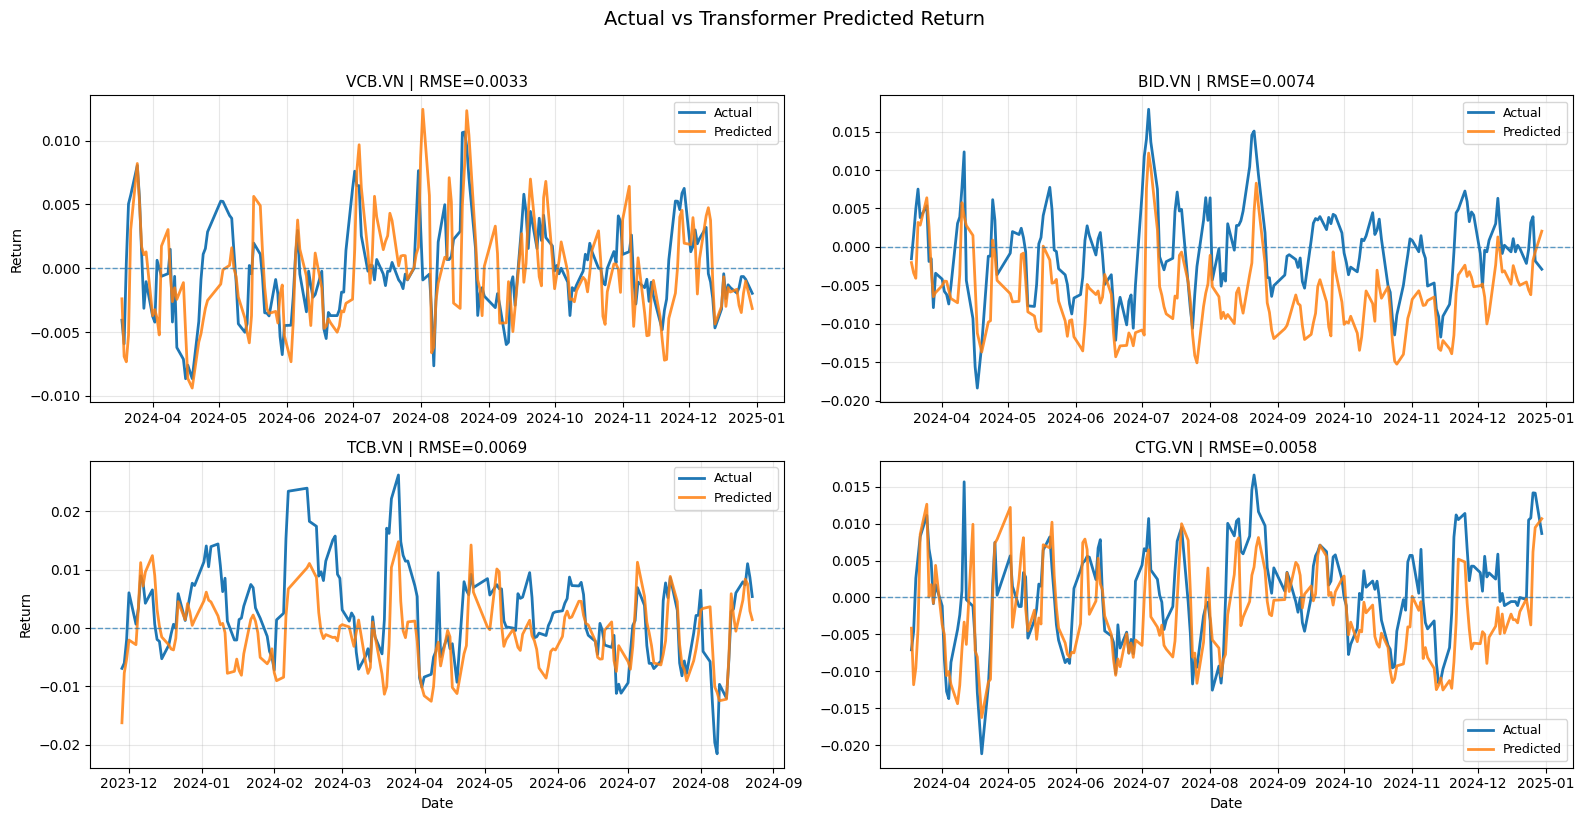

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

def safe_auc(y_true_bin, y_prob):
    if len(np.unique(y_true_bin)) < 2:
        return np.nan
    return roc_auc_score(y_true_bin, y_prob)

summary_rows = []

for tk in models.keys():
    X_train_seq, X_test_seq, y_train_seq, y_test_seq = splits[tk]
    model = models[tk]
    y_mu, y_sd = meta[tk]["y_mu"], meta[tk]["y_sd"]

    # ---- predict both heads ----
    y_reg_z_pred, y_up_prob = model.predict(X_test_seq, verbose=0)
    y_reg_z_pred = y_reg_z_pred.reshape(-1)
    y_up_prob    = y_up_prob.reshape(-1)

    # inverse transform regression
    y_pred = y_reg_z_pred * y_sd + y_mu

    # regression metrics
    mse  = mean_squared_error(y_test_seq, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_seq, y_pred)

    # direction metrics use y_up_prob with tuned threshold (use LAST 20% of train as val proxy)
    # We'll tune threshold on the *train tail* stored in the same run:
    # (simple approach: reuse your existing X_val,y_val by re-deriving from train)
    val_size = max(1, int(0.2 * len(X_train_seq)))
    X_val = X_train_seq[-val_size:]
    y_val = y_train_seq[-val_size:]
    y_val_true = (y_val > 0).astype(int)

    _, y_val_prob = model.predict(X_val, verbose=0)
    y_val_prob = y_val_prob.reshape(-1)

    best_t, best_f1 = tune_threshold(y_val_true, y_val_prob, lo=0.3, hi=0.7, n=81)

    y_true_bin = (y_test_seq > 0).astype(int)
    y_pred_bin = (y_up_prob > best_t).astype(int)

    directional_acc = accuracy_score(y_true_bin, y_pred_bin)
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    recall    = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1        = f1_score(y_true_bin, y_pred_bin, zero_division=0)
    auc       = safe_auc(y_true_bin, y_up_prob)

    cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    summary_rows.append({
        "Ticker": tk,
        "N_test_seq": len(y_test_seq),
        "RMSE": rmse,
        "MAE": mae,
        "MSE": mse,
        "Directional_Acc": directional_acc,
        "Precision_Up": precision,
        "Recall_Up": recall,
        "F1_Up": f1,
        "AUC": auc,
        "Best_Threshold": best_t,
        "Val_F1_at_bestT": best_f1,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    })

summary_df = pd.DataFrame(summary_rows).sort_values("RMSE").reset_index(drop=True)
display_cols = ["Ticker","N_test_seq","RMSE","MAE","Directional_Acc","Precision_Up","Recall_Up","F1_Up","AUC","Best_Threshold","Val_F1_at_bestT","TN","FP","FN","TP"]
print(summary_df[display_cols].to_string(index=False))

import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_pred_all(
    tickers,
    splits,
    models,
    meta,
    df,
    n_last=200,
    figsize=(16, 8)
):
    """
    Vẽ Actual vs Predicted return cho nhiều mã (multi-panel)
    tickers: list ticker, ví dụ ["VCB.VN","BID.VN","TCB.VN","CTG.VN"]
    """

    n = len(tickers)
    nrows = int(np.ceil(n / 2))
    ncols = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=False)
    axes = axes.flatten()

    for i, tk in enumerate(tickers):
        ax = axes[i]

        X_train_seq, X_test_seq, y_train_seq, y_test_seq = splits[tk]
        model = models[tk]
        y_mu, y_sd = meta[tk]["y_mu"], meta[tk]["y_sd"]

        # Predict (regression head)
        y_reg_z_pred, _ = model.predict(X_test_seq, verbose=0)
        y_pred = y_reg_z_pred.reshape(-1) * y_sd + y_mu

        # Dates corresponding to test
        dft = df[df["ticker"] == tk].sort_values("date").reset_index(drop=True)
        test_dates = dft["date"].iloc[-len(y_test_seq):].values

        # Take last N points
        if n_last is not None:
            y_test_plot = y_test_seq[-n_last:]
            y_pred_plot = y_pred[-n_last:]
            date_plot   = test_dates[-n_last:]
        else:
            y_test_plot = y_test_seq
            y_pred_plot = y_pred
            date_plot   = test_dates

        ax.plot(date_plot, y_test_plot, label="Actual", linewidth=2)
        ax.plot(date_plot, y_pred_plot, label="Predicted", linewidth=2, alpha=0.85)
        ax.axhline(0, linestyle="--", linewidth=1, alpha=0.7)

        ax.set_title(
            f"{tk} | RMSE={np.sqrt(np.mean((y_test_plot - y_pred_plot)**2)):.4f}",
            fontsize=11
        )
        ax.grid(alpha=0.3)

        if i % 2 == 0:
            ax.set_ylabel("Return")

        if i >= (nrows - 1) * ncols:
            ax.set_xlabel("Date")

        ax.legend(fontsize=9)

    # Remove empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(
        "Actual vs Transformer Predicted Return",
        fontsize=14,
        y=1.02
    )

    plt.tight_layout()
    plt.show()

print("📊 ACTUAL vs TRANSFORMER PREDICTED RETURN")
plot_actual_vs_pred_all(
    tickers=["VCB.VN", "BID.VN", "TCB.VN", "CTG.VN"],
    splits=splits,
    models=models,
    meta=meta,
    df=df,
    n_last=200
)

# Hybrid Transformer


In [24]:
import numpy as np
import pandas as pd
import pywt
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =========================
# 0) Reproducibility
# =========================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# 1) Wavelet features (safe level)
# =========================
def rolling_wavelet_features(x_window, wavelet="db4", level=3):
    x = np.asarray(x_window, dtype=np.float32)
    x = x[np.isfinite(x)]
    L = len(x)

    if L < 16 or np.allclose(x, 0):
        return {
            "wav_EA": 0.0,
            **{f"wav_ED{i}": 0.0 for i in range(1, level+1)},
            "wav_detail_ratio": 0.0,
            "wav_denoised_last": 0.0
        }

    x = x - np.mean(x)

    # SAFE LEVEL
    w = pywt.Wavelet(wavelet)
    max_lvl = pywt.dwt_max_level(data_len=L, filter_len=w.dec_len)
    lvl = int(min(level, max_lvl)) if max_lvl > 0 else 1

    coeffs = pywt.wavedec(x, wavelet=wavelet, level=lvl, mode="symmetric")
    cA = coeffs[0]
    cDs = coeffs[1:]

    EA = float(np.sum(cA**2))
    ED = [float(np.sum(cd**2)) for cd in cDs]
    total = EA + sum(ED) + 1e-12
    detail_ratio = float(sum(ED) / total)

    # denoise
    cD1 = cDs[-1] if len(cDs) else np.array([0.0], dtype=np.float32)
    cD1 = cD1[np.isfinite(cD1)]
    if len(cD1) == 0:
        sigma = 1e-12
    else:
        med = np.median(cD1)
        sigma = np.median(np.abs(cD1 - med)) / 0.6745 + 1e-12

    uthresh = sigma * np.sqrt(2*np.log(L + 1e-12))

    coeffs_dn = [cA]
    for cd in cDs:
        coeffs_dn.append(pywt.threshold(cd, value=uthresh, mode="soft"))

    x_dn = pywt.waverec(coeffs_dn, wavelet=wavelet, mode="symmetric")
    denoised_last = float(x_dn[-1]) if len(x_dn) > 0 and np.isfinite(x_dn[-1]) else 0.0

    out = {"wav_EA": EA if np.isfinite(EA) else 0.0}
    ED_reversed = list(reversed(ED))  # ED1..EDlvl
    for i in range(1, level+1):
        out[f"wav_ED{i}"] = float(ED_reversed[i-1]) if i-1 < len(ED_reversed) and np.isfinite(ED_reversed[i-1]) else 0.0

    out["wav_detail_ratio"] = detail_ratio if np.isfinite(detail_ratio) else 0.0
    out["wav_denoised_last"] = denoised_last
    return out

# =========================
# 2) FFT features (add log-energy stabilization)
# =========================
def rolling_fft_features(x_window, n_top=3):
    x = np.asarray(x_window, dtype=np.float32)
    x = x[np.isfinite(x)]
    L = len(x)

    if L < 16 or np.allclose(x, 0):
        return {"fft_energy": 0.0, "fft_low_ratio": 0.0, "fft_centroid": 0.0, "fft_topk_mag": 0.0}

    x = x - np.mean(x)

    X = np.fft.rfft(x)
    mag = (np.abs(X) + 1e-12).astype(np.float32)
    power = mag**2
    total_energy = float(np.sum(power) + 1e-12)

    n_bins = len(mag)
    low_end = max(2, int(0.10 * n_bins))
    low_energy = float(np.sum(power[1:low_end]) + 1e-12)
    low_ratio = float(low_energy / total_energy)

    sum_mag = float(np.sum(mag))
    if sum_mag <= 0:
        centroid = 0.0
    else:
        freqs = np.arange(n_bins, dtype=np.float32)
        centroid = float(np.sum(freqs * mag) / (sum_mag + 1e-12))

    mag_nodc = mag.copy()
    mag_nodc[0] = 0.0
    finite_mag = mag_nodc[np.isfinite(mag_nodc)]
    k = min(n_top, max(1, n_bins-1))
    if len(finite_mag) == 0:
        topk_mag = 0.0
    else:
        k = min(k, len(finite_mag))
        topk = np.partition(finite_mag, -k)[-k:]
        topk_mag = float(np.mean(topk)) if len(topk) else 0.0

    # log energy helps stabilize scale
    return {
        "fft_energy": float(np.log(total_energy)) if np.isfinite(total_energy) else 0.0,
        "fft_low_ratio": low_ratio if np.isfinite(low_ratio) else 0.0,
        "fft_centroid": centroid if np.isfinite(centroid) else 0.0,
        "fft_topk_mag": topk_mag if np.isfinite(topk_mag) else 0.0
    }

# =========================
# 3) Aux features: avoid zero-padding -> use shorter windows early
# =========================
def add_fft_wavelet_aux_features(df_one_ticker, ret_col="return", aux_window=64, wavelet="db4", level=3):
    d = df_one_ticker.sort_values("date").reset_index(drop=True).copy()
    r = d[ret_col].astype(np.float32)
    r_past = r.shift(1)

    aux_rows = []
    for i in range(len(d)):
        # use available past length (shorter window early) instead of all-zeros
        start = max(0, i-aux_window)
        win = r_past.iloc[start:i].values
        if len(win) < 16:
            # still too short -> neutral
            aux_rows.append({**rolling_fft_features(np.zeros(16)), **rolling_wavelet_features(np.zeros(16), wavelet, level)})
        else:
            aux_rows.append({**rolling_fft_features(win), **rolling_wavelet_features(win, wavelet, level)})

    aux_df = pd.DataFrame(aux_rows)
    return pd.concat([d, aux_df], axis=1)

# =========================
# 4) Sequence builder
# =========================
def create_sequences_with_aux(X_seq_features, X_aux_features, y, seq_len):
    Xs, Xa, ys = [], [], []
    for i in range(seq_len, len(y)):
        Xs.append(X_seq_features[i-seq_len:i])
        Xa.append(X_aux_features[i])
        ys.append(y[i])
    return np.array(Xs), np.array(Xa), np.array(ys)

# =========================
# 5) Transformer (Pre-LN) + last pooling
# =========================
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position: int, d_model: int):
        super().__init__()
        pos = np.arange(position)[:, np.newaxis]
        i   = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads  = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

def transformer_encoder_preln(x, num_heads, key_dim, ff_dim, dropout=0.2, d_model=64):
    # Pre-LN
    x_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    attn_out = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(x_norm, x_norm)
    attn_out = tf.keras.layers.Dropout(dropout)(attn_out)
    x = tf.keras.layers.Add()([x, attn_out])

    x_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    ff = tf.keras.layers.Dense(ff_dim, activation="relu")(x_norm2)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    ff = tf.keras.layers.Dense(d_model)(ff)
    x = tf.keras.layers.Add()([x, ff])
    return x

def build_hybrid_fft_wav_transformer(
    seq_input_shape,
    aux_input_dim,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    num_blocks=3,
    dropout=0.2,
    use_conv_frontend=True,
    aux_mlp_units=(64, 32)
):
    seq_in = tf.keras.Input(shape=seq_input_shape, name="seq_in")
    aux_in = tf.keras.Input(shape=(aux_input_dim,), name="aux_in")

    # Transformer branch
    x = tf.keras.layers.Dense(d_model)(seq_in)
    if use_conv_frontend:
        x = tf.keras.layers.Conv1D(filters=d_model, kernel_size=3, padding="causal", activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout)(x)

    x = PositionalEncoding(position=seq_input_shape[0], d_model=d_model)(x)

    key_dim = max(8, d_model // num_heads)
    for _ in range(num_blocks):
        x = transformer_encoder_preln(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, d_model=d_model)

    # last pooling instead of GAP
    x = tf.keras.layers.Lambda(lambda t: t[:, -1, :])(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    # Aux branch
    a = tf.keras.layers.LayerNormalization()(aux_in)
    for u in aux_mlp_units:
        a = tf.keras.layers.Dense(u, activation="relu")(a)
        a = tf.keras.layers.Dropout(dropout)(a)

    # Fusion
    h = tf.keras.layers.Concatenate()([x, a])
    h = tf.keras.layers.Dense(64, activation="relu")(h)
    h = tf.keras.layers.Dropout(dropout)(h)

    y_reg_z = tf.keras.layers.Dense(1, name="y_reg_z")(h)
    y_up    = tf.keras.layers.Dense(1, activation="sigmoid", name="y_up")(h)

    return tf.keras.Model([seq_in, aux_in], [y_reg_z, y_up])

# =========================
# 6) Focal loss for direction (reduces FP explosions)
# =========================
def focal_bce(gamma=2.0, alpha=0.25):
    # y_true in {0,1}
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        bce = -(y_true * tf.math.log(y_pred) + (1.0 - y_true) * tf.math.log(1.0 - y_pred))
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        focal = alpha_t * tf.pow((1.0 - p_t), gamma) * bce
        return tf.reduce_mean(focal)
    return loss

# =========================
# 7) Threshold tuning: optimize DA or balanced acc
# =========================
def tune_threshold_metric(y_true_bin, y_prob, lo=0.1, hi=0.9, n=161, metric="da"):
    ths = np.linspace(lo, hi, n)
    best_t, best_score = 0.5, -1

    y_true_bin = np.asarray(y_true_bin).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    for t in ths:
        y_hat = (y_prob > t).astype(int)
        if metric == "da":
            score = accuracy_score(y_true_bin, y_hat)
        elif metric == "bal_acc":
            # balanced accuracy = (TPR + TNR)/2
            tn, fp, fn, tp = confusion_matrix(y_true_bin, y_hat, labels=[0,1]).ravel()
            tpr = tp / (tp + fn + 1e-12)
            tnr = tn / (tn + fp + 1e-12)
            score = 0.5 * (tpr + tnr)
        else:  # f1
            score = f1_score(y_true_bin, y_hat, zero_division=0)

        if score > best_score:
            best_score, best_t = score, t

    return float(best_t), float(best_score)

def safe_auc(y_true_bin, y_prob):
    if len(np.unique(y_true_bin)) < 2:
        return np.nan
    return roc_auc_score(y_true_bin, y_prob)

# =========================
# 8) TRAIN + EVALUATE per ticker (with deadzone + purge gap + better early stop)
# =========================
LOOKBACK   = 30
AUX_WINDOW = 64
WAVELET    = "db4"
WAV_LEVEL  = 3

# deadzone to reduce label noise
EPS_UP = 0.0003  # bạn có thể thử 0.0002 / 0.0005

# val purge gap (avoid bleed)
VAL_GAP = 5

df = df.copy()
df["date"] = pd.to_datetime(df["date"])

non_feature = ['date', 'ticker', 'target']
base_feature_cols = [c for c in df.columns if c not in non_feature]

models, scalers, splits, meta = {}, {}, {}, {}
summary_rows = []

for tk, dft in df.groupby("ticker"):
    dft = dft.sort_values("date").reset_index(drop=True)

    dft = add_fft_wavelet_aux_features(
        dft, ret_col="return",
        aux_window=AUX_WINDOW,
        wavelet=WAVELET, level=WAV_LEVEL
    )

    aux_cols = [c for c in dft.columns if c.startswith("fft_") or c.startswith("wav_")]
    if len(aux_cols) == 0:
        raise ValueError("No aux cols found. Check prefix names.")

    X_seq_raw = dft[base_feature_cols].values.astype(np.float32)
    X_aux_raw = dft[aux_cols].values.astype(np.float32)
    y_raw     = dft["target"].values.astype(np.float32)

    if len(dft) < (LOOKBACK + 80):
        print(f"⚠️ {tk}: dữ liệu quá ít ({len(dft)} dòng) -> bỏ qua")
        continue

    split_index = int(len(dft) * 0.8)
    X_seq_train_raw, X_seq_test_raw = X_seq_raw[:split_index], X_seq_raw[split_index:]
    X_aux_train_raw, X_aux_test_raw = X_aux_raw[:split_index], X_aux_raw[split_index:]
    y_train_raw, y_test_raw         = y_raw[:split_index], y_raw[split_index:]

    seq_scaler = RobustScaler()
    aux_scaler = RobustScaler()

    X_seq_train = seq_scaler.fit_transform(X_seq_train_raw)
    X_seq_test  = seq_scaler.transform(X_seq_test_raw)

    X_aux_train = aux_scaler.fit_transform(X_aux_train_raw)
    X_aux_test  = aux_scaler.transform(X_aux_test_raw)

    Xtr_seq, Xtr_aux, ytr = create_sequences_with_aux(X_seq_train, X_aux_train, y_train_raw, LOOKBACK)
    Xte_seq, Xte_aux, yte = create_sequences_with_aux(X_seq_test,  X_aux_test,  y_test_raw,  LOOKBACK)

    # validation tail from train WITH GAP
    val_size = max(10, int(0.2 * len(Xtr_seq)))
    cut = len(Xtr_seq) - val_size
    cut2 = max(1, cut - VAL_GAP)

    X_tr_seq, X_val_seq = Xtr_seq[:cut2], Xtr_seq[cut:]
    X_tr_aux, X_val_aux = Xtr_aux[:cut2], Xtr_aux[cut:]
    y_tr, y_val         = ytr[:cut2], ytr[cut:]

    # standardize regression target on train only
    y_mu = float(np.mean(y_tr))
    y_sd = float(np.std(y_tr) + 1e-8)
    y_tr_z  = ((y_tr  - y_mu) / y_sd).astype(np.float32)
    y_val_z = ((y_val - y_mu) / y_sd).astype(np.float32)

    # direction labels with deadzone
    y_tr_up  = (y_tr > EPS_UP).astype(np.float32)
    y_val_up = (y_val > EPS_UP).astype(np.float32)

    # build model
    model = build_hybrid_fft_wav_transformer(
        seq_input_shape=(LOOKBACK, Xtr_seq.shape[2]),
        aux_input_dim=Xtr_aux.shape[1],
        d_model=64, num_heads=4, ff_dim=128, num_blocks=3,
        dropout=0.2, use_conv_frontend=True,
        aux_mlp_units=(64, 32)
    )

    # direction loss: focal
    dir_loss = focal_bce(gamma=2.0, alpha=0.35)

    opt = Adam(learning_rate=8e-4, clipnorm=1.0)
    model.compile(
        optimizer=opt,
        loss={"y_reg_z": tf.keras.losses.Huber(delta=1.0), "y_up": dir_loss},
        loss_weights={"y_reg_z": 0.8, "y_up": 1.2},
        metrics={
            "y_up": [tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Precision(name="prec"), tf.keras.metrics.Recall(name="rec")]
        }
    )

    early_stop = EarlyStopping(
        monitor="val_y_up_auc", mode="max",
        patience=10, restore_best_weights=True
    )
    rlr = ReduceLROnPlateau(
        monitor="val_y_up_auc", mode="max",
        factor=0.5, patience=4, min_lr=1e-5, verbose=1
    )

    pos = float(y_tr_up.mean())
    print(f"\n===== Training HYBRID for {tk} | UpRatio={pos:.3f} | EPS_UP={EPS_UP} =====")

    model.fit(
        [X_tr_seq, X_tr_aux], {"y_reg_z": y_tr_z, "y_up": y_tr_up},
        validation_data=([X_val_seq, X_val_aux], {"y_reg_z": y_val_z, "y_up": y_val_up}),
        epochs=120, batch_size=32,
        callbacks=[early_stop, rlr],
        verbose=1
    )

    models[tk] = model
    scalers[tk] = {"seq": seq_scaler, "aux": aux_scaler}
    splits[tk] = (Xtr_seq, Xtr_aux, Xte_seq, Xte_aux, ytr, yte)
    meta[tk] = {"y_mu": y_mu, "y_sd": y_sd, "up_ratio": pos, "eps_up": EPS_UP}

    # ===== Evaluate =====
    y_reg_z_pred, y_up_prob = model.predict([Xte_seq, Xte_aux], verbose=0)
    y_reg_z_pred = y_reg_z_pred.reshape(-1)
    y_up_prob    = y_up_prob.reshape(-1)
    y_pred = y_reg_z_pred * y_sd + y_mu

    rmse = float(np.sqrt(mean_squared_error(yte, y_pred)))
    mae  = float(mean_absolute_error(yte, y_pred))

    # tune threshold on val (optimize DA or balanced acc, not just F1)
    _, y_val_prob = model.predict([X_val_seq, X_val_aux], verbose=0)
    y_val_prob = y_val_prob.reshape(-1)
    y_val_true = (y_val > EPS_UP).astype(int)

    best_t, best_score = tune_threshold_metric(y_val_true, y_val_prob, lo=0.1, hi=0.9, n=161, metric="bal_acc")

    y_true_bin = (yte > EPS_UP).astype(int)
    y_pred_bin = (y_up_prob > best_t).astype(int)

    directional_acc = float(accuracy_score(y_true_bin, y_pred_bin))
    precision = float(precision_score(y_true_bin, y_pred_bin, zero_division=0))
    recall    = float(recall_score(y_true_bin, y_pred_bin, zero_division=0))
    f1        = float(f1_score(y_true_bin, y_pred_bin, zero_division=0))
    auc       = float(safe_auc(y_true_bin, y_up_prob))

    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()

    summary_rows.append({
        "Ticker": tk,
        "N_test_seq": len(yte),
        "RMSE": rmse,
        "MAE": mae,
        "Directional_Acc": directional_acc,
        "Precision_Up": precision,
        "Recall_Up": recall,
        "F1_Up": f1,
        "AUC": auc,
        "Best_Threshold": float(best_t),
        "Val_balAcc_at_bestT": float(best_score),
        "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp)
    })

summary_df = pd.DataFrame(summary_rows).sort_values("Directional_Acc", ascending=False).reset_index(drop=True)
print(summary_df.to_string(index=False))



===== Training HYBRID for BID.VN | UpRatio=0.492 | EPS_UP=0.0003 =====
Epoch 1/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - loss: 0.9958 - y_reg_z_loss: 0.8955 - y_up_auc: 0.5671 - y_up_loss: 0.2324 - y_up_prec: 0.6045 - y_up_rec: 0.3280 - val_loss: 0.1995 - val_y_reg_z_loss: 0.1431 - val_y_up_auc: 0.7635 - val_y_up_loss: 0.0733 - val_y_up_prec: 0.7212 - val_y_up_rec: 0.7732 - learning_rate: 8.0000e-04
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.4066 - y_reg_z_loss: 0.3698 - y_up_auc: 0.6735 - y_up_loss: 0.0927 - y_up_prec: 0.6247 - y_up_rec: 0.5063 - val_loss: 0.1751 - val_y_reg_z_loss: 0.1171 - val_y_up_auc: 0.7453 - val_y_up_loss: 0.0713 - val_y_up_prec: 0.7885 - val_y_up_rec: 0.4227 - learning_rate: 8.0000e-04
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.3382 - y_reg_z_loss: 0.3075 - y_up_auc: 0.7353 - y_up_loss: 0.0766 - y_up_prec: 0.7209 - y_up_rec: 0.4910 - val_loss: 0.1687 - val_y_reg_z_loss: 0.1201 - val_y_up_auc: 0.8650 - val_y_up_loss: 

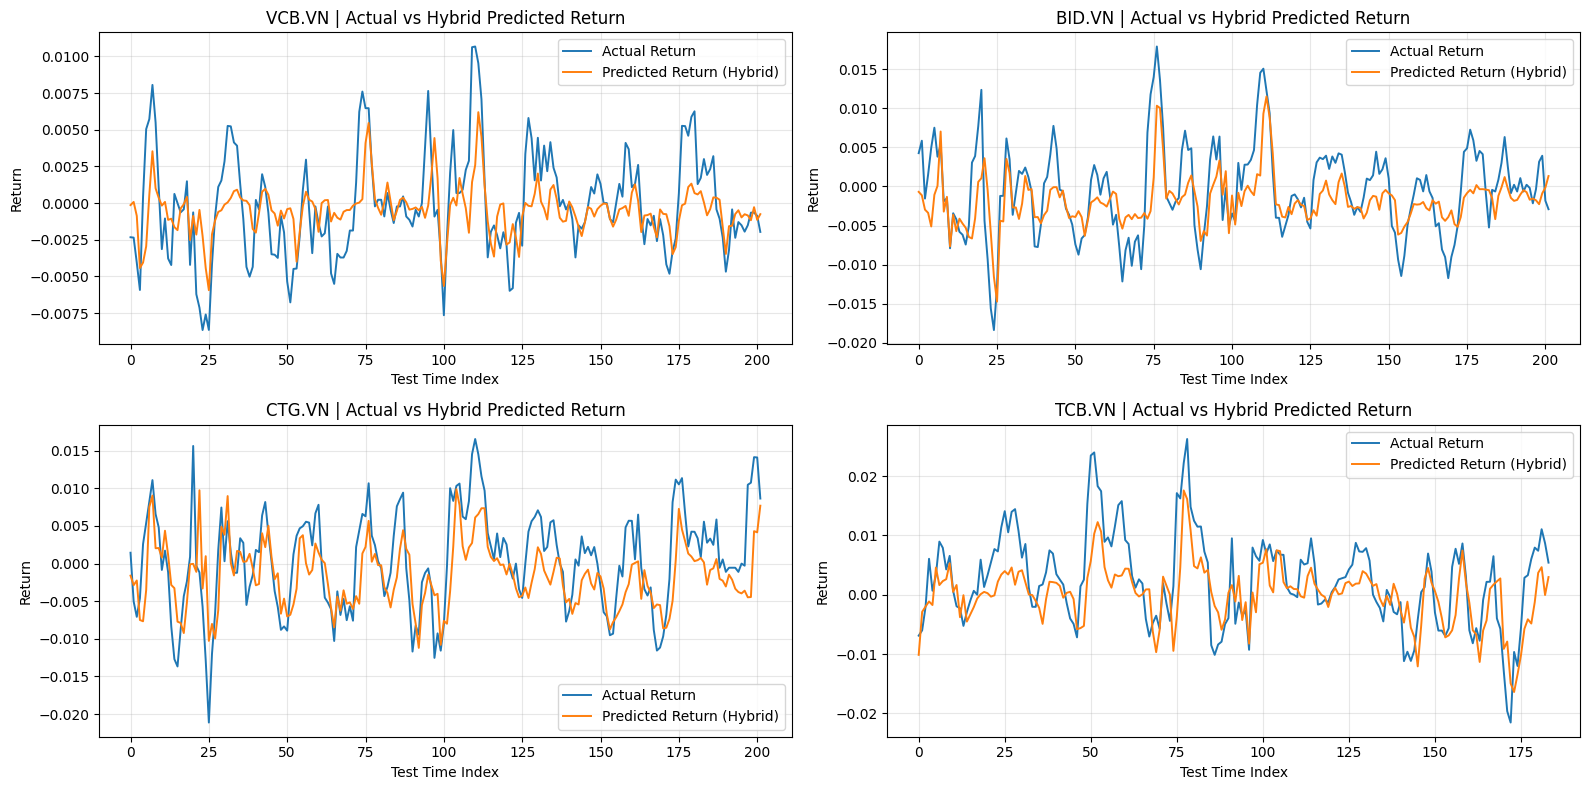

In [25]:

# store predictions for later use (global)
pred_store = {}

# ✅ ưu tiên đúng 4 mã bạn dùng trong báo cáo
preferred = ["VCB.VN", "BID.VN", "CTG.VN", "TCB.VN"]

# lấy những mã thực sự tồn tại trong splits
tickers = [t for t in preferred if t in splits]

# nếu thiếu (ví dụ bạn train ít mã), bổ sung bằng các mã còn lại trong splits
if len(tickers) < 4:
    for t in splits.keys():
        if t not in tickers:
            tickers.append(t)
        if len(tickers) == 4:
            break

# nếu vẫn <4 thì vẽ theo số lượng thực tế
n = len(tickers)
if n == 0:
    raise ValueError("splits is empty. Bạn cần train xong và có dữ liệu trong splits trước khi plot.")

rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

for i in range(rows * cols):
    ax = axes[i]
    if i >= n:
        ax.axis("off")
        continue

    tk = tickers[i]
    (Xtr_seq, Xtr_aux, Xte_seq, Xte_aux, ytr, yte) = splits[tk]
    model = models[tk]
    y_mu  = meta[tk]["y_mu"]
    y_sd  = meta[tk]["y_sd"]

    # predict
    y_reg_z_pred, y_up_prob = model.predict([Xte_seq, Xte_aux], verbose=0)
    y_reg_z_pred = y_reg_z_pred.reshape(-1)
    y_up_prob    = y_up_prob.reshape(-1)

    # denormalize
    y_pred = y_reg_z_pred * y_sd + y_mu

    # save
    pred_store[tk] = {"y_true": yte, "y_pred": y_pred, "y_up_prob": y_up_prob}

    # plot
    ax.plot(yte, label="Actual Return", linewidth=1.4)
    ax.plot(y_pred, label="Predicted Return (Hybrid)", linewidth=1.4)
    ax.set_title(f"{tk} | Actual vs Hybrid Predicted Return")
    ax.set_xlabel("Test Time Index")
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Sumary